# SpecAugment with TorchAudio
by [Zach Caceres](https://github.com/zcaceres) and [Jenny Cai](https://github.com/qcai2002)

This notebook feature a Pytorch implementation of the data augmentation techniques in [SpecAugment](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) by Google Brain.

The techniques are:
- Time Warp
- Frequency Mask
- Time Mask

SpecAugment reports that Frequency Mask and Time Mask were the most effective augmentations and less computationally expensive than Time Warp. We included Time Warp for completeness.

### Prerequisites
Be sure you've run `install.sh` before running this notebook!

### Setup

In [1]:
#Export
from collections import namedtuple
import random

import torch
import torchaudio
from torchaudio import transforms
import os
import numpy as np

This converts our implementation of `sparse_image_warp` into a Python file we can import.

In [2]:
os.system("python notebook2script.py SparseImageWarp.ipynb")

Traceback (most recent call last):
  File "/Users/sumit/python stuff/Audio signal processing/spec_augment-master/notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'


256

In [2]:
from exp.nb_SparseImageWarp import sparse_image_warp

ModuleNotFoundError: No module named 'exp'

## Loading Audio

Let's check out our sample wav file (a snippet of background chatter from a party). We'll load it into a `namedtuple` to keep the signal & sample rate tied together.

In [3]:
from IPython.display import Audio

In [4]:
sample = 'debussy.wav'

In [5]:
AudioData = namedtuple('AudioData', ['sig', 'sr'])

In [6]:
audio = AudioData(*torchaudio.load(sample))

In [7]:
audio

AudioData(sig=tensor([[-0.0174, -0.0357, -0.0500,  ...,  0.0091,  0.0087,  0.0096]]), sr=22050)

In [8]:
def check_audio(aud):
    display(Audio(data=aud.sig, rate=aud.sr))

In [9]:
check_audio(audio)

## Wav to (Mel)Spectrogram

Simple wrapper for `torchaudio`'s transforms to make a decibel-scale Melspectrogram. Borrowed from [fastai-audio](https://github.com/zcaceres/fastai-audio), with some tweaks.

In [10]:
class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip. This method is sourced from an earlier release of torchaudio and
    is no longer present in current versions.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db


In [11]:
def tfm_spectro(ad:Audio, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sample_rate=ad.sr, n_mels=n_mels, n_fft=n_fft, win_length=ws, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    if to_db_scale: mel = SpectrogramToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [12]:
spectro = tfm_spectro(audio, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)

/Users/sumit/opt/anaconda3/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [13]:
# # Run this cell if you want to use your spectrogram to run the SparseImageWarp notebook.
# %store spectro

## Viewing a spectrogram

In [14]:
import matplotlib.pyplot as plt

In [15]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,1)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

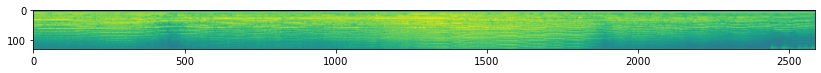

torch.Size([1, 128, 2584])

In [16]:
tensor_to_img(spectro)

## Time Warp

Time Warp is described as:
> Time warping is applied via the function sparse image warp of tensorflow. Given a log mel spectrogram with τ time steps, we view it as an image where the time axis is horizontal and the frequency axis is vertical. A random point along the horizontal line passing through the center of the image within the time steps (W, τ − W) is to be warped either to the left or right by a distance w chosen from a uniform distribution from 0 to the time warp parameter W along that line.

Intuitively we squish/stretch the audio in a given direction bounded by the `W` parameter we select.

NOTE:
`sparse_image_warp` does not exist in Pytorch, so you can see our implementation in the SparseImageWarp.ipynb notebook. Our implementation skips certain features like add clamping.

You should be careful with your `W` parameter because it's highly dependent on your audio and spectrogram. 

*Sanity check your spectrograms if you're using this transform.*

In [17]:
#Export
def time_warp(spec, W=50):
    num_rows = spec.shape[2]
    spec_len = spec.shape[1]
    device = spec.device

    # adapted from https://github.com/DemisEom/SpecAugment/
    pt = (num_rows - 2* W) * torch.rand([1], dtype=torch.float) + W # random point along the time axis
    src_ctr_pt_freq = torch.arange(0, spec_len // 2)  # control points on freq-axis
    src_ctr_pt_time = torch.ones_like(src_ctr_pt_freq) * pt  # control points on time-axis
    src_ctr_pts = torch.stack((src_ctr_pt_freq, src_ctr_pt_time), dim=-1)
    src_ctr_pts = src_ctr_pts.float().to(device)

    # Destination
    w = 2 * W * torch.rand([1], dtype=torch.float) - W# distance
    dest_ctr_pt_freq = src_ctr_pt_freq
    dest_ctr_pt_time = src_ctr_pt_time + w
    dest_ctr_pts = torch.stack((dest_ctr_pt_freq, dest_ctr_pt_time), dim=-1)
    dest_ctr_pts = dest_ctr_pts.float().to(device)

    # warp
    source_control_point_locations = torch.unsqueeze(src_ctr_pts, 0)  # (1, v//2, 2)
    dest_control_point_locations = torch.unsqueeze(dest_ctr_pts, 0)  # (1, v//2, 2)
    warped_spectro, dense_flows = sparse_image_warp(spec, source_control_point_locations, dest_control_point_locations)
    return warped_spectro.squeeze(3)

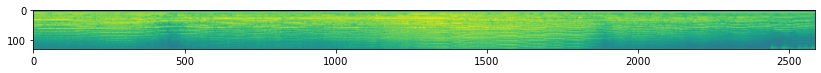

torch.Size([1, 128, 2584])

NameError: name 'sparse_image_warp' is not defined

In [28]:
def test_time_warp():
    tensor_to_img(time_warp(spectro))
tensor_to_img(spectro)    
test_time_warp()

## Frequency Mask

Frequency masking is described as:
> Frequency masking is applied so that f consecutive mel
frequency channels [f0, f0 + f) are masked, where f is first chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

Intuitively, this is similar to cutout in computer vision workflows. We mask certain frequency bands with either the mean value of the spectrogram or zero.

In [18]:
#Export
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

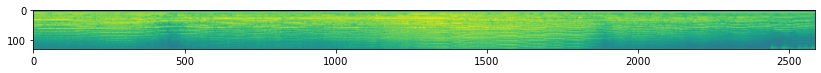

torch.Size([1, 128, 2584])

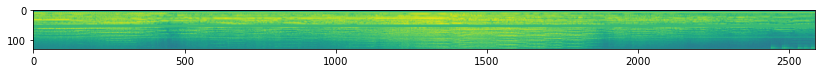

torch.Size([1, 128, 2584])

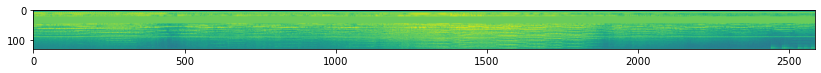

torch.Size([1, 128, 2584])

In [19]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask()

## Time Mask

Time masking is described as:
> Time masking is applied so that t consecutive time steps
[t0, t0 + t) are masked, where t is first chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t). We introduce an upper bound on the time mask so that a time mask cannot be wider than p times the number of time steps.

Intuitively, this is similar to cutout and the frequency mask above. We mask certain time ranges with the mean value of the spectrogram or zero.

In [20]:
#Export
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

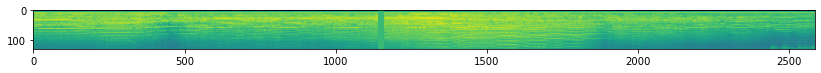

torch.Size([1, 128, 2584])

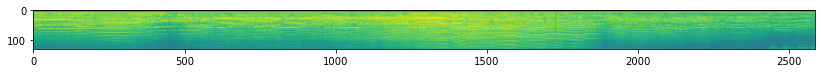

torch.Size([1, 128, 2584])

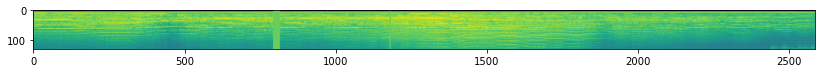

torch.Size([1, 128, 2584])

In [21]:
def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

## Combined
Here we combine all three transforms.

In [22]:
combined = time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)
tensor_to_img(combined)

NameError: name 'sparse_image_warp' is not defined

## Performance

### CPU

In [35]:
%%timeit -n 10
time_warp(spectro)

NameError: name 'sparse_image_warp' is not defined

In [26]:
%%timeit -n 100
freq_mask(spectro)

116 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit -n 100
time_mask(spectro)

95 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit -n 10
time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)

91 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### GPU

In [36]:
cspectro = spectro.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [37]:
%%timeit -n 100
time_warp(cspectro)

NameError: name 'cspectro' is not defined

In [31]:
%%timeit -n 100
freq_mask(cspectro)

79.1 µs ± 7.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit -n 100
time_mask(cspectro)

79.3 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit -n 100
time_mask(freq_mask(time_warp(cspectro), num_masks=2), num_masks=2)

12.2 ms ± 58.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
